# NAG Experiments

Gettin the data

In [1]:
import datautils
import pandas as pd
import modelutils as mu
import nesterov
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import itertools

In [2]:
DATASET = "Dataset/ML-CUP23-TR.csv"
RESULTS = "Results/"
PLOT = "Plots/"
RUNS = "FullRuns/"

In [3]:
df_cup = pd.read_csv(DATASET, skiprows=6)
df_cup.rename(columns={"# Training set: ID": "ID"}, inplace=True)

In [4]:
df_cup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1000 non-null   int64  
 1   x1      1000 non-null   float64
 2   x2      1000 non-null   float64
 3   x3      1000 non-null   float64
 4   x4      1000 non-null   float64
 5   x5      1000 non-null   float64
 6   x6      1000 non-null   float64
 7   x7      1000 non-null   float64
 8   x8      1000 non-null   float64
 9   x9      1000 non-null   float64
 10  x10     1000 non-null   float64
 11  y1      1000 non-null   float64
 12  y2      1000 non-null   float64
 13  y3      1000 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 109.5 KB


In [5]:
X_train, y_train = datautils.obtain_features_targets(df_cup)
print(X_train.shape, y_train.shape)

input_size = X_train.shape[1]
output_size = y_train.shape[1]
input_size, output_size

(1000, 10) (1000, 3)


(10, 3)

## General experiments for algorithms comparison

In [25]:
for HIDDEN_SIZE in [1000]:
    model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=10, init="fan-in")
    conditioning = np.linalg.cond(model_true.input_weights)
    print(
        f"Conditioning of input weights for HIDDEN_SIZE {HIDDEN_SIZE}: {conditioning}"
    )

    A = model_true.hidden_activations(X_train)
    conditioning = np.linalg.cond(A)
    print(f"Conditioning of A for HIDDEN_SIZE {HIDDEN_SIZE}: {conditioning}")

    AtA = A.T @ A  # + alpha * np.eye(model.hidden_size)

    # guarantee posdef in case of numerical errors (happens for large hidden sizes)
    eig_min = np.min(np.linalg.eigvals(AtA))
    old_tau = max(0, -eig_min)
    BtB = AtA + (old_tau + 1e-2) * np.eye(model_true.hidden_size)

    conditioning = np.linalg.cond(BtB)
    print(f"Conditioning of BtB for HIDDEN_SIZE {HIDDEN_SIZE}: {conditioning}")

    eigs = np.linalg.eigvalsh(BtB)
    print(eigs)

Conditioning of input weights for HIDDEN_SIZE 1000: 1.186061206190153
Conditioning of A for HIDDEN_SIZE 1000: 31586009897.833237
Conditioning of BtB for HIDDEN_SIZE 1000: 14527687.604671381
[1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1

In [6]:
results_dict = {
    "Hidden size": [],
    "Mu": [],
    "Beta": [],
    "Epsilon": [],
    "Alpha": [],
    "Seed": [],
    "Initialization type": [],
    "Train": [],
    "Validation": [],
    "Time": [],
    "Epochs": [],
}

In [7]:
# hyperparameters

# per 2000 1e-2 alpha
# per 1000 1e-2 alpha
# per 100 1e-2 alpha
# per 50 1e-8 alpha

hidden_size_list = [
    2000,
    50,
    100,
    1000,
]
lr_list = ["auto"]
beta_list = ["optimal", 0.9, 0.3, 0.6, 0.99, 0, "schedule"]
alpha_list = [1e-2]
epsilon_list = [np.float64(1e-10)]

In [8]:
worked = None
for HIDDEN_SIZE, LEARNING_RATE, BETA, ALPHA, EPSILON in itertools.product(
    hidden_size_list, lr_list, beta_list, alpha_list, epsilon_list
):
    print(
        f"HIDDEN_SIZE: {HIDDEN_SIZE}, LEARNING_RATE: {LEARNING_RATE}, BETA: {BETA}, ALPHA: {ALPHA}, EPSILON: {EPSILON}"
    )
    # initialize dictionary for results
    results_dict = {
        "Hidden size": [],
        "Mu": [],
        "Beta": [],
        "Epsilon": [],
        "Alpha": [],
        "Seed": [],
        "Initialization type": [],
        "Train": [],
        "Time": [],
        "Time int": [],
        "Epochs": [],
    }

    # if worked is not None and not type(LEARNING_RATE) == str:
    #     if (
    #         LEARNING_RATE < worked
    #     ):  # an higher learning rate has already been tested, and it converged
    #         continue

    # loop over seeds
    for seed in range(3):

        # compute exact solution using qr which has guaranteed better numerical stability
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        model_true.compute_wout_system_qr(X_train, y_train, alpha=ALPHA)

        # initialize model
        model = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)

        print("starting seed", seed)

        # measure time
        start = time.process_time()

        # train model
        (
            final_model,
            loss_train_history,
            sol_dist_history,
            grad_history,
            epochs,
            exec_time_loop,
            has_problem,
        ) = nesterov.nag(
            model,
            X_train,
            y_train,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=10000000,  # we are sure unless of numerical errors of the convergence, just here to prevent runs spanning hours
            eps=EPSILON,
            exact_solution=model_true.output_weights,
            # fast_mode=True,
            # verbose=True,
        )

        end = time.process_time()

        if has_problem:
            print(
                f"Problem with ELM {HIDDEN_SIZE} {LEARNING_RATE} {BETA} {ALPHA} {EPSILON} {seed}"
            )
            continue
        else:
            worked = LEARNING_RATE

        # save results
        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append("fan-in")
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Time"].append(end - start)
        results_dict["Time int"].append(exec_time_loop)
        results_dict["Epochs"].append(epochs)

        # guard is true if not using fast_mode (i.e. all iterations are saved)
        if len(loss_train_history) > 1:
            # save all iterations using pickle
            with open(
                f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",
                "wb",
            ) as f:
                pickle.dump(
                    {
                        "model": final_model,
                        "loss_train_history": loss_train_history,
                        "sol_dist_history": sol_dist_history,
                        "grad_history": grad_history,
                    },
                    f,
                )

    if has_problem:
        continue

    # no results obtained because there was an error
    if len(results_dict["Seed"]) == 0:
        continue

    df_results = pd.DataFrame(results_dict)
    df_results.to_csv(
        f"{RESULTS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}-trialnew1.csv",
        index=False,
    )

HIDDEN_SIZE: 2000, LEARNING_RATE: auto, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-10
starting seed 0


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [ ]:
hidden_size_list = [50, 100, 1000, 2000]
lr_list = [
    "col",
    "optimal",
    1e-4,
    1e-5,
    1e-6,
    1e-7,
]
beta_list = ["optimal"]
alpha_list = [1e-2]
epsilon_list = [np.float64(1e-12)]

In [ ]:
worked = None
for HIDDEN_SIZE, LEARNING_RATE, BETA, ALPHA, EPSILON in itertools.product(
    hidden_size_list, lr_list, beta_list, alpha_list, epsilon_list
):
    print(
        f"HIDDEN_SIZE: {HIDDEN_SIZE}, LEARNING_RATE: {LEARNING_RATE}, BETA: {BETA}, ALPHA: {ALPHA}, EPSILON: {EPSILON}"
    )
    # initialize dictionary for results
    results_dict = {
        "Hidden size": [],
        "Mu": [],
        "Beta": [],
        "Epsilon": [],
        "Alpha": [],
        "Seed": [],
        "Initialization type": [],
        "Train": [],
        "Time": [],
        "Time int": [],
        "Epochs": [],
    }

    # if worked is not None and not type(LEARNING_RATE) == str:
    #     if (
    #         LEARNING_RATE < worked
    #     ):  # an higher learning rate has already been tested, and it converged
    #         continue

    # loop over seeds
    for seed in range(3):

        # compute exact solution using qr which has guaranteed better numerical stability
        model_true = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)
        model_true.compute_wout_system_qr(X_train, y_train, alpha=ALPHA)

        # initialize model
        model = mu.ELM(input_size, HIDDEN_SIZE, output_size, seed=seed)

        print("starting seed", seed)

        # measure time
        start = time.process_time()

        # train model
        (
            final_model,
            loss_train_history,
            sol_dist_history,
            grad_history,
            epochs,
            exec_time_loop,
            has_problem,
        ) = nesterov.nag(
            model,
            X_train,
            y_train,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=10000000,  # we are sure unless of numerical errors of the convergence, just here to prevent runs spanning hours
            eps=EPSILON,
            exact_solution=model_true.output_weights,
            # fast_mode=True,
            # verbose=True,
        )

        end = time.process_time()

        if has_problem:
            print(
                f"Problem with ELM {HIDDEN_SIZE} {LEARNING_RATE} {BETA} {ALPHA} {EPSILON} {seed}"
            )
            continue
        else:
            worked = LEARNING_RATE

        # save results
        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append("fan-in")
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Time"].append(end - start)
        results_dict["Time int"].append(exec_time_loop)
        results_dict["Epochs"].append(epochs)

        # guard is true if not using fast_mode (i.e. all iterations are saved)
        if len(loss_train_history) > 1:
            # save all iterations using pickle
            with open(
                f"{RUNS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}_{seed}.pkl",
                "wb",
            ) as f:
                pickle.dump(
                    {
                        "model": final_model,
                        "loss_train_history": loss_train_history,
                        "sol_dist_history": sol_dist_history,
                        "grad_history": grad_history,
                    },
                    f,
                )

    if has_problem:
        continue

    # no results obtained because there was an error
    if len(results_dict["Seed"]) == 0:
        continue

    df_results = pd.DataFrame(results_dict)
    df_results.to_csv(
        f"{RESULTS}ELM_{HIDDEN_SIZE}_{LEARNING_RATE}_{BETA}_{ALPHA}_{EPSILON}-trialnew1.csv",
        index=False,
    )

HIDDEN_SIZE: 50, LEARNING_RATE: col, BETA: optimal, ALPHA: 0.01, EPSILON: 1e-12
starting seed 0


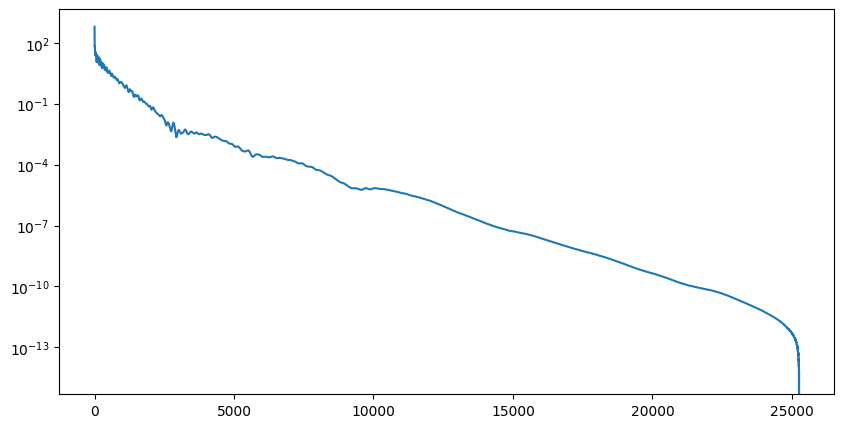

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(1, len(loss_train_history) + 1),
    loss_train_history
    - min(
        loss_train_history
    ),  # mu.compute_loss(y_train, model_true.predict(X_train), alpha=ALPHA),
)
plt.yscale("log")

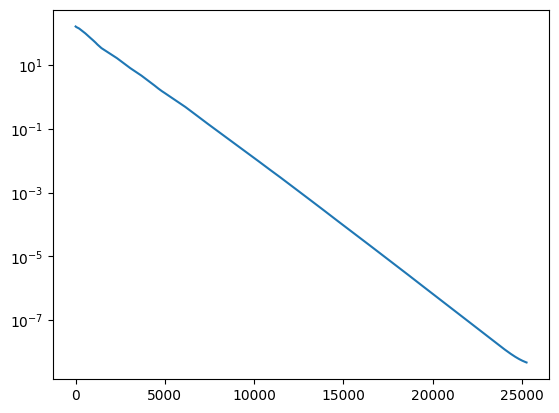

In [12]:
plt.plot(
    np.arange(1, len(sol_dist_history) + 1),
    sol_dist_history,
    label="Train",
)
plt.yscale("log")
# plt.xscale("log")

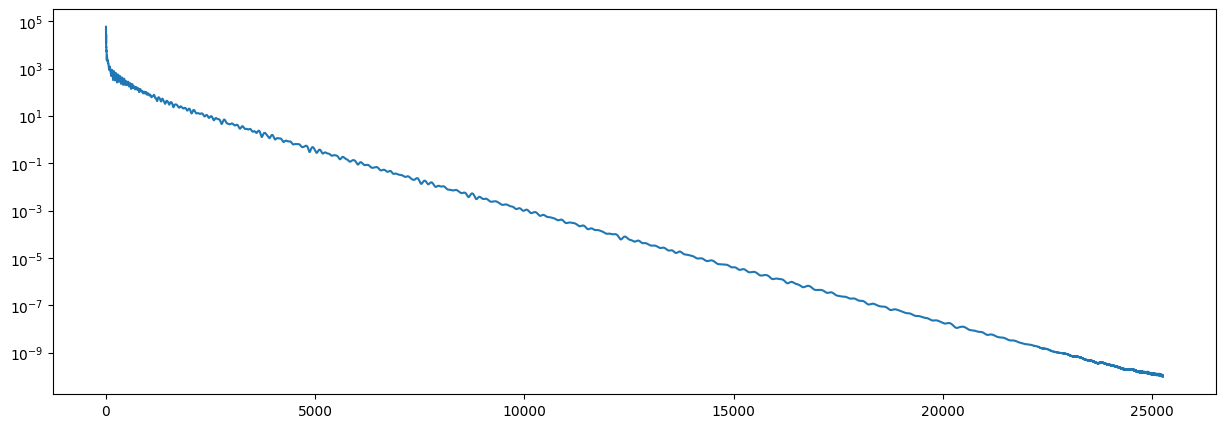

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(
    np.arange(1, len(grad_history)),
    grad_history[1:],
    label="Train",
)
plt.yscale("log")

In [ ]:
# from results get dataframes with 100 hidden, auto lr, schedule beta, 1e-2 epsilon, for every alpha
alphas = [3e-1, 1e-1, 1e-2]
res_list = []

for alpha in alphas:
    res_list.append(
        pd.read_csv(f"{RESULTS}ELM_2000_auto_schedule_{alpha}_0.01-prime.csv")
    )

# concatenate dataframes
df_results = pd.concat(res_list, ignore_index=True)
df_results.groupby("Alpha")["Validation"].mean().sort_values()

## Experiments for initialization comparisons

In [ ]:
# dictionary for results, with keys the strings and values empty lists
results_dict = {
    "Hidden size": [],
    "Mu": [],
    "Beta": [],
    "Epsilon": [],
    "Alpha": [],
    "Seed": [],
    "Initialization type": [],
    "Train": [],
    "Validation": [],
    "Time": [],
    "Epochs": [],
}

In [ ]:
# hyperparameters
HIDDEN_SIZE = 1000
LEARNING_RATE = "auto"
BETA = 0
ALPHA = 1e-8
EPSILON = 1e-10

In [ ]:
# iterate over multiple seeds

for initialization in ["fan-in", "std"]:
    for seed in range(10):
        # initialize the model
        model = mu.ELM(
            input_size,
            HIDDEN_SIZE,
            output_size,
            seed=seed,
            init=initialization,
        )

        # measure the time
        start_time = time.process_time()

        # train model
        final_model, loss_train_history, loss_val_history, epochs, _ = nesterov.nag(
            model,
            X_train,
            y_train,
            X_val,
            y_val,
            lr=LEARNING_RATE,
            alpha=ALPHA,
            beta=BETA,
            max_epochs=1000000,
            eps=EPSILON,
            # fast_mode=True,
            # verbose=True,
        )

        end_time = time.process_time()

        # save the results

        results_dict["Hidden size"].append(HIDDEN_SIZE)
        results_dict["Mu"].append(LEARNING_RATE)
        results_dict["Beta"].append(BETA)
        results_dict["Epsilon"].append(EPSILON)
        results_dict["Alpha"].append(ALPHA)
        results_dict["Seed"].append(seed)
        results_dict["Initialization type"].append(initialization)
        results_dict["Train"].append(loss_train_history[-1])
        results_dict["Validation"].append(loss_val_history[-1])
        results_dict["Time"].append(end_time - start_time)
        results_dict["Epochs"].append(epochs)

        # save all iterations using pickle
        with open(
            f"{initialization}_{seed}.pkl",
            "wb",
        ) as f:
            pickle.dump(
                {
                    "model": final_model,
                    "loss_train_history": loss_train_history,
                    "loss_val_history": loss_val_history,
                },
                f,
            )

        # plot results
        plt.plot(
            np.arange(1, len(loss_train_history) + 1),
            loss_train_history,
            label="Train",
        )
        plt.plot(
            np.arange(1, len(loss_train_history) + 1),
            loss_val_history,
            label="Validation",
        )
        plt.legend()
        # set title and labels
        plt.title(f"Loss {initialization} {seed}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        # set axis scale
        plt.xscale("log")
        plt.yscale("log")
        # fix y axis to have comparable plots
        plt.ylim(0.001, 1000)

        # save the plot
        plt.savefig(PLOT + f"loss_{initialization}_{seed}.png")
        plt.show()


results = pd.DataFrame(results_dict)
results.to_csv(RESULTS + f"results_initialization_{HIDDEN_SIZE}.csv", index=False)

In [ ]:
# show average training, validation and time, show also the standard deviation
results.groupby("Initialization type")[["Train", "Validation", "Time"]].agg(
    ["mean", "std"]
)